In [17]:
#Import Relevant Modules
import re
from datetime import datetime, date
from time import sleep
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

In [18]:
#Retrive today's date
date = date.today()

In [19]:
def getPMONData(filename):
    '''
    Extract PMON Temperature data from txt file

    @param:
        filename -> str
    @return:
        list with data from each PMON
    '''
    
    data = [] 
    pmon_pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\].*?PMON\s+temps:\s*(\{[^}]+\})', re.I)
    with open(filename, "r") as f:
        for line in f:
            p = pmon_pattern.search(line)
            if p:
                time_str = p.group(1)
                log_time = datetime.strptime(time_str, "%H:%M:%S").time()
                
                pmon_dict = eval(p.group(2))
                pmon_1 = pmon_dict[1]
                pmon_2 = pmon_dict[2]
                pmon_3 = pmon_dict[3]
                pmon_4 = pmon_dict[4]
                pmon_5 = pmon_dict[5]
                pmon_6 = pmon_dict[6]

                data.append((log_time, pmon_1, pmon_2, pmon_3, pmon_4, pmon_5, pmon_6))
    return data

In [20]:
def createPMONCSV(pmon_data):
    '''

    @param:
    pmon_data: list of data -> list
    '''
    with open(f'pmon_log-{str(date)}.csv', 'w', newline='') as out:
        writer = csv.writer(out)
        writer.writerow(['Time', 'PMON 1', 'PMON_2', 'PMON_3', 'PMON_4', 'PMON_5', 'PMON_6'])   # header
        writer.writerows(pmon_data)

    print(f'{len(pmon_data)} rows written to pmon_log-{str(date)}.csv')

In [ ]:
def getPMONGraph(csv_file, start_time = '00:00:01', end_time = '23:59:59'):
    '''
    Displays PMON Graph

    args:
        csv_file : File name -> str
        start_time : -> str
    
    '''
    pmon_result = pd.read_csv(csv_file, parse_dates=['Time'])
    pmon_result = pmon_result.to_numpy()
    time_DNE = False

    time = pmon_result[:,0]
    pmon_data = {}

    try:
        start_index = time.tolist().index(str(start_time))
        end_index = time.tolist().index(str(end_time))
    except ValueError:
        print("Timeframe does not exist")
        time_DNE = True

    ports = {1:'PMON_1', 2:'PMON_2', 3:'PMON_3', 4:'PMON_4', 5:'PMON_5', 6:'PMON_6'}

    for idx, value in ports.items():
        if time_DNE == True:
            pmon_data[value] = pmon_result[:, idx].tolist()
        elif time_DNE == False:
            pmon_data[value] = pmon_result[start_index:end_index, idx].tolist()

    #Method 1 - Completely remove the disconnected value (data will be shorter than the rest)
    #for key in ports.values():
    #    pmon_data[key] = [float(x) for x in pmon_data[key] if x not in ('DISCONNECTED','SENSOR_ERROR')]

    #Method 2 - fill data points that are disconnected with previous value
    for key in ports.values():
        if pmon_data[key][0] in ['DISCONNECTED','SENSOR_ERROR', 'None']:
            pmon_data[key] = [float(x) for x in pmon_data[key] if x not in ('DISCONNECTED','SENSOR_ERROR', 'None')]
        else:
            for i in range(len(pmon_data[key])):
                if pmon_data[key][i] in ['DISCONNECTED','SENSOR_ERROR','None']:
                    pmon_data[key][i] = pmon_data[key][i - 1]
            pmon_data[key] = [float(x) for x in pmon_data[key]]


    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot()
    
    for key in ports.values():
        if pmon_data[key]:
            print(f'Average Temperature for {key}: {np.mean(pmon_data[key])}')
        else:
            print(f'No data from {key}')
        ax.plot(pmon_data[key], label=key)
    
    ax.set_xlabel('Time Elapsed (s)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Temperature Graph')
    ax.grid()
    ax.legend(loc='upper right')

    # Set number of X axis tick marks
    ax.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Format x-axis to show only the time (HH:MM)
    time_format = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(time_format)

    # Rotate x axis labels
    ax.figure.autofmt_xdate()

    plt.show()


24108 rows written to pmon_log-2025-06-10.csv


C:\Users\Ian\AppData\Local\Temp\ipykernel_16684\1460648327.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pmon_result = pd.read_csv(csv_file, parse_dates=['Time'])


Timeframe does not exist
Average Temperature for PMON_1: nan
Average Temperature for PMON_2: nan
Average Temperature for PMON_3: nan
Average Temperature for PMON_4: nan
Average Temperature for PMON_5: nan
Average Temperature for PMON_6: nan


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

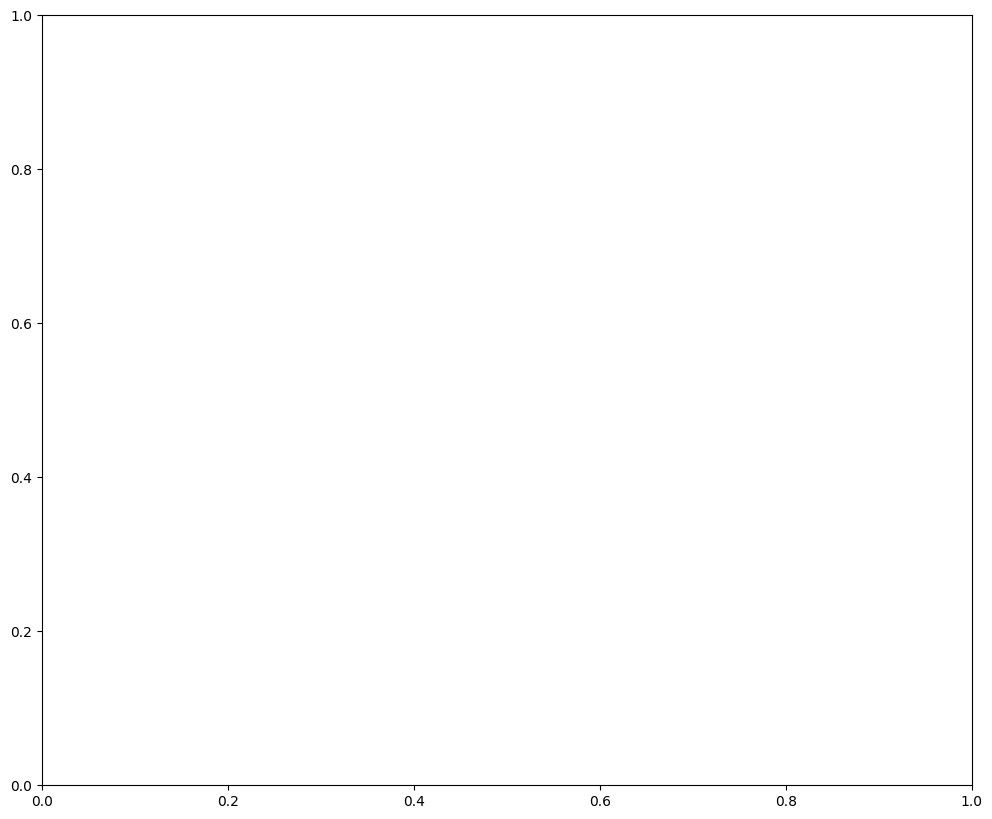

In [26]:
createPMONCSV(getPMONData('Data samples/log_export_2025-06-09_17-10-43.txt'))
getPMONGraph(f'pmon_log-{str(date)}.csv')

In [ ]:
while 1 :
    createPMONCSV(getPMONData('log_export_2025-06-09_17-10-43.txt'))
    getPMONGraph(f'pmon_log-{str(date)}.csv')
    sleep(10)
    clear_output(wait=True)